In [31]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import agents
import utils

importlib.reload(agents);
importlib.reload(utils);

In [32]:
polarity = "unknown_polarity"

# Active Inference

In [33]:
def marginal_q_target(particles, num_targets, i=1):
    return np.histogram(particles['q'][:,i], bins=num_targets, range=(0, num_targets), weights=particles['w'], density=True)[0]

def marginal_q_f(particles, i=0, bins=10, range=(0,1) ):
    return np.histogram(particles['q'][:,i], bins=bins, range=range, weights=particles['w'], density=True)[0]

In [34]:
def merge_logs(*logs):
    out = logs[0]
    for log in logs[1:]:
        for k, v in log['conditions'].items():
            out['conditions'][k] = np.concatenate((out['conditions'][k], log['conditions'][k]))
            
    out['experiments'] =  out['experiments'] + log['experiments']
    return out

In [79]:
# load result file
bins = np.linspace(0-0.0125, max_f+0.0125, int(42*max_f+1))

def load_log(filename, existing_logs=None, bins=bins):
    print('loading...', filename)
    new_log = np.load(filename, allow_pickle=True)[0]
    # preprocess data
    first_config = new_log['experiments'][0]['config']
    max_f = first_config['max_f']
    num_targets = first_config['num_targets']
    bins = np.linspace(0-0.0125, max_f+0.0125, int(42*max_f+1))

    print('preprocessing...')
    for run in tqdm(new_log['experiments']):
        beliefs = run['result']['beliefs']
        q_target = np.asarray([marginal_q_target(particles=q, num_targets=num_targets) for q in beliefs])
        q_f0 = np.asarray([marginal_q_f(particles=q, i=0, bins=bins) for q in beliefs])
        run['result']['q_target'] = q_target
        run['result']['q_f0'] = q_f0
        
    if existing_logs is None:
        return new_log
    else:
        return merge_logs(existing_logs, new_log)
        
#filename = f'iter_18_ainf_32_3200_symmetric_{polarity}_False_5.npy'
#filenames = [f'ainf_32_3200_symmetric_{polarity}_False_5_0.1.npy', f'ainf_32_3200_symmetric_{polarity}_False_5_0.2.npy', f'ainf_32_3200_symmetric_{polarity}_False_5_0.3.npy']
filenames = [f'ainf_32_3200_symmetric_unknown_polarity_False_5.npy']

log_ainf=None
for filename in filenames:
    log_ainf = load_log(filename, log_ainf)


loading... ainf_32_3200_symmetric_unknown_polarity_False_5.npy
preprocessing...


100%|██████████| 320/320 [00:48<00:00,  6.64it/s]


## Single Run

TypeError: len() of unsized object

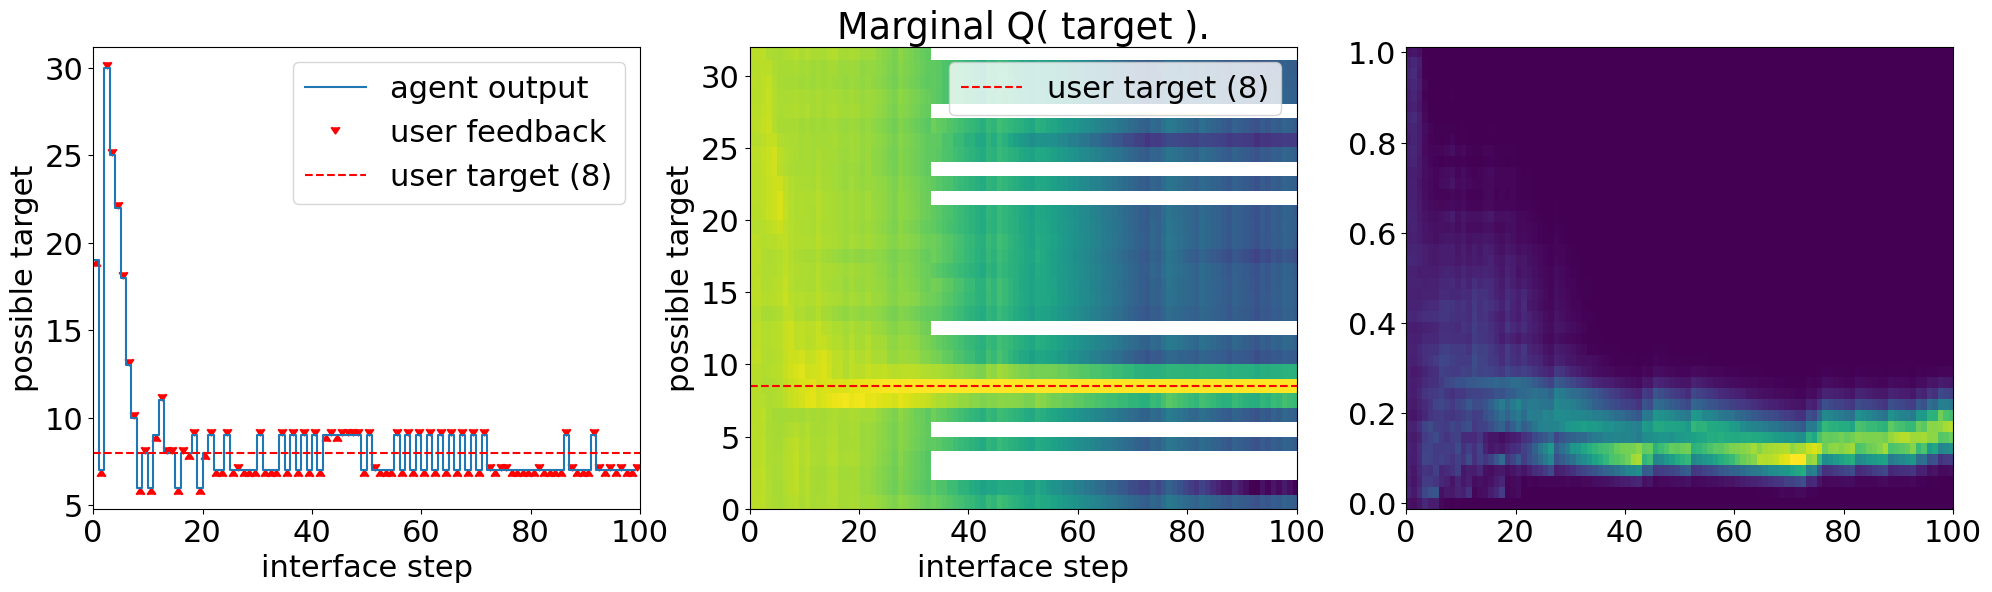

In [39]:
# single run analysis
plt.rcParams.update({'font.size': 22})
start, end = [0, 100] # timesteps to plot

# query condition
conditions = log_ainf['conditions']
experiments = log_ainf['experiments']
target = conditions['target']
f0 = conditions['f0']
f1 = conditions['f1']
indices = np.array((target == 8) * np.isclose(f0, 0.1) * np.isclose(f1, 0.1), dtype=bool)
runs = np.asarray(experiments)[indices]

run = runs[1]
# unpack run data
config = run['config']
result = run['result']
num_targets = config['num_targets']
user_target = config['target']
user_f0 = config['f0']
user_f1 = config['f1']
max_f = config['max_f']
oo_user = result['oo_user']
oo_system = result['oo_system']
q_target = result['q_target']
q_f0 = result['q_f0']

num_plots = 3
fig, axes = plt.subplots(1, num_plots, figsize=(num_plots*8, 6))
utils.plot_interaction_sequence(oo_user[start:end], oo_system[start:end], user_target, ax=axes[0])
utils.plot_target_belief_distribution_sequence(q_target[start:end], user_target, cscale='log', ax=axes[1])
utils.plot_f_belief_distribution_sequence(q_f0[start:end], user_f0, bins, ax=axes[2])
fig.tight_layout()

## Aggregate Statistics with Successive Episodes

In [80]:
# decision rule evaluation - AInf
conditions = log_ainf['conditions']
experiments = log_ainf['experiments']
target = conditions['target']
f0 = conditions['f0']
f1 = conditions['f1']

f_i = 0.1

# query condition
indices = np.array(np.isclose(f0, f_i), dtype=bool) # all targets, all repetitions
runs = np.asarray(experiments)[indices]
max_num_steps = runs[0]['config']['max_num_steps']

q_thresholds = np.linspace(0, 1, 21) # iterate over thresholds

ainf_mean_num_steps = []
ainf_mean_accuracy = []
for episode in range(5):
    ainf_mean_num_steps.append([])
    ainf_mean_accuracy.append([])
    for q_threshold in q_thresholds:
        num_steps = []
        accuracy = []
        for run in runs:
            q = run['result']['q_target'][episode*(max_num_steps+1):(episode+1)*(max_num_steps+1)]
            max_q = q.max(axis=1)
            _num_steps = np.argmax(max_q >= q_threshold) # returns 0 if all elements False
            _num_steps = max_num_steps if max_q[_num_steps] < q_threshold else _num_steps
            num_steps.append(_num_steps+1) # log run result
            accuracy.append(np.argmax(q[_num_steps]) == run['config']['target'])
        
        ainf_mean_num_steps[episode].append(np.mean(num_steps))
        ainf_mean_accuracy[episode].append(np.mean(accuracy))

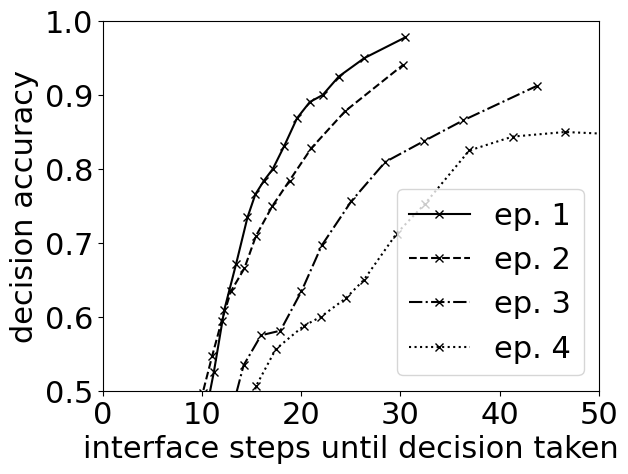

In [81]:
fig, ax = plt.subplots()

linestyle = ['-','--','-.', None,':']
linestyle = ['solid','dashed','dashdot','dotted']
episodes = [0, 1, 2, 3]
for i in range(4):
    episode = episodes[i]
    ax.plot(ainf_mean_num_steps[episode][:-1], ainf_mean_accuracy[episode][:-1], 'x', linestyle=linestyle[i], color='black', label=f'ep. {episode+1}')

ax.set_xlim([0, 50])
ax.set_ylim([0.5, 1])
ax.set_xlabel('interface steps until decision taken')
ax.set_ylabel('decision accuracy')

ax.legend()

In [ ]:
## Preprocessing

In [82]:
# preprocessing
conditions = log_ainf['conditions']
experiments = log_ainf['experiments']
target = conditions['target']
f0 = conditions['f0']
f1 = conditions['f1']

bins = np.linspace(0-0.0125, max_f+0.0125, int(42*max_f+1))
print(bins)

stats_by_error = {}
print('unique f0', np.unique(f0))
for f_i in np.unique(f0):
    # query condition
    indices = np.array(np.isclose(f0, f_i), dtype=bool) # all targets, all repetitions
    runs = np.asarray(experiments)[indices]
    
    # get all marginal belief sequences of input errors across all runs
    target_belief_sequences = []
    f_belief_sequences = []
    for run in tqdm(runs):
        user_target = run['config']['target']
        user_f = run['config']['f0']
        num_targets = run['config']['num_targets']
        beliefs = run['result']['beliefs']
        # target
        target_belief_sequences.append(run['result']['q_target'][:,user_target])
        # f
        i_user_f = np.digitize(user_f, bins[1:])
        f_belief_sequences.append(run['result']['q_f0'][:,i_user_f])
    
    target_quantiles = np.quantile(target_belief_sequences, [0.5, 0.25, 0.75], axis=0)
    f_quantiles = np.quantile(f_belief_sequences, [0.5, 0.25, 0.75], axis=0)
    stats_by_error[f'{f_i:.2f}'] = {
        'q_target': target_quantiles,
        'q_f': f_quantiles
    }

[-0.0125      0.01190476  0.03630952  0.06071429  0.08511905  0.10952381
  0.13392857  0.15833333  0.1827381   0.20714286  0.23154762  0.25595238
  0.28035714  0.3047619   0.32916667  0.35357143  0.37797619  0.40238095
  0.42678571  0.45119048  0.47559524  0.5         0.52440476  0.54880952
  0.57321429  0.59761905  0.62202381  0.64642857  0.67083333  0.6952381
  0.71964286  0.74404762  0.76845238  0.79285714  0.8172619   0.84166667
  0.86607143  0.89047619  0.91488095  0.93928571  0.96369048  0.98809524
  1.0125    ]
unique f0 [0.1]


100%|██████████| 320/320 [00:00<00:00, 127401.74it/s]


In [83]:
## How quickly does AInf infer error?

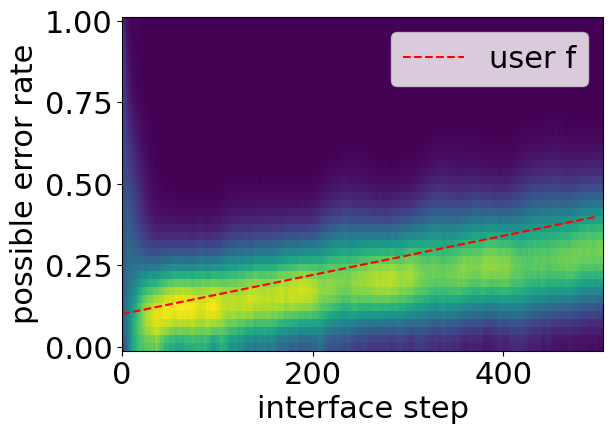

In [84]:
fig, ax = plt.subplots()

indices = np.array(np.isclose(f0, f) * np.isclose(f1, f), dtype=bool)
runs = np.asarray(experiments)[indices]
mean_q_f = np.zeros_like(run['result']['q_f0'])
for run in runs:
    mean_q_f += run['result']['q_f0']

utils.plot_f_belief_distribution_sequence(mean_q_f, runs[0]['config']['f0'] + np.linspace(0, 0.3, 500), bins, ax=ax)
ax.set_title(None)
fig.tight_layout()

TypeError: len() of unsized object

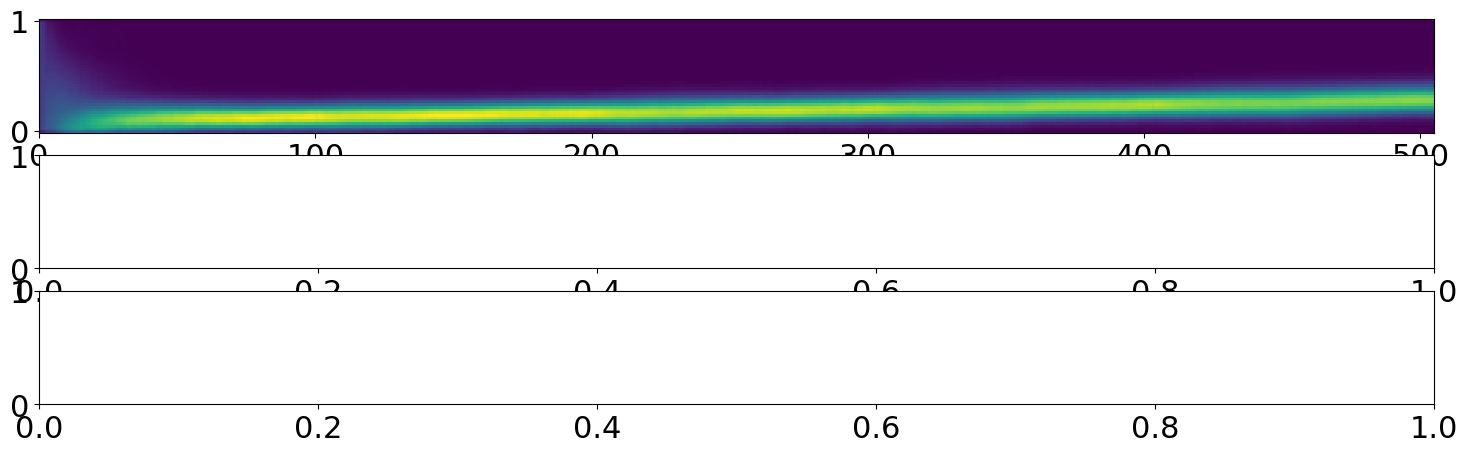

In [68]:
# one heatmap showing the mean belief about error across all runs
fig, axes = plt.subplots(3, 1, figsize=(3*6, 5))

for i, f in enumerate([0.1]):
    indices = np.array(np.isclose(f0, f) * np.isclose(f1, f), dtype=bool)
    runs = np.asarray(experiments)[indices]
    mean_q_f = np.zeros_like(run['result']['q_f0'])
    for run in runs:
        mean_q_f += run['result']['q_f0']
    
    utils.plot_f_belief_distribution_sequence(mean_q_f, runs[0]['config']['f0'], bins, ax=axes[i])


axes[1].get_yaxis().set_visible(False)
axes[2].get_yaxis().set_visible(False)
fig.tight_layout()

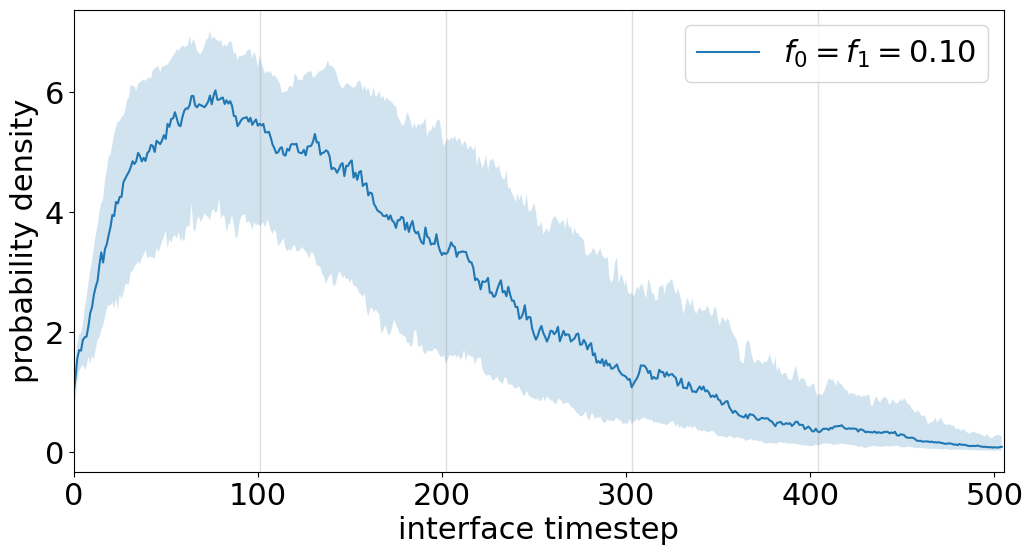

In [70]:
# RQ 1how quickly does KL-control learn about input error?

fig, ax = plt.subplots(figsize=(12, 6))

num_steps = 101
num_steps_display = 505
errors = ['0.10', '0.20', '0.30', '0.40']
errors = ['0.10', '0.20', '0.30']
errors = ['0.10']

for f_i, stats in zip(errors, [stats_by_error[f] for f in errors]):
    q_target = stats['q_target']
    q_f = stats['q_f']
    num_episodes = int(q_f.shape[1] / num_steps)
    ax.plot(q_f[0,:], label=f'$f_0=f_1=${f_i}')
    ax.fill_between(np.arange(q_f.shape[1]), q_f[1,:], q_f[2,:], alpha=0.2)
    
ylim = ax.get_ylim()
for i in range(1, num_episodes):
    # indicate episode limits with gray vertical bars
    ax.plot([i*num_steps]*2, ylim, 'gray', linewidth=1, alpha=0.25, label="episode end" if i==0 else None)
    
ax.set_xlabel('interface timestep')
ax.set_ylabel('probability density')
ax.set_ylim(ylim)
ax.set_xlim([0, num_steps_display])
ax.legend()

In [ ]:
## How Quickly does Ainf learn about user target

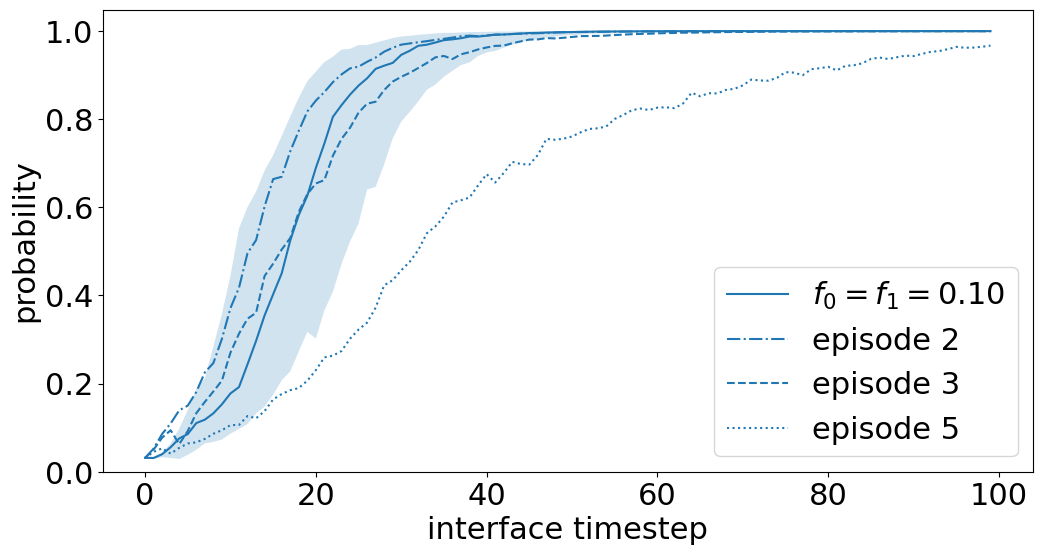

In [71]:

fig, ax = plt.subplots(figsize=(12, 6))

num_steps = 101
errors = ['0.10','0.20','0.30']
errors = ['0.10']
num_steps_display = 100

linestyle = ['-', '-.', '--', None,':']

for f_i, stats in zip(errors, [stats_by_error[f] for f in errors]):

    q_target = stats['q_target']
    num_episodes = int(q_f.shape[1] / num_steps)
    for i in [0, 1, 2, 4]:
        start, end = i*num_steps, i*num_steps + num_steps_display
        if i==0:
            p = ax.plot(q_target[0,start:end], linestyle=linestyle[i], label=f'$f_0=f_1=${f_i}')
            ax.fill_between(np.arange(num_steps_display), q_target[1,start:end], q_target[2,start:end], alpha=0.2)
            color = p[0].get_color()
        else:
            label = f'episode {i+1}' if (f_i==errors[-1]) else None
            ax.plot(q_target[0,start:end], linestyle=linestyle[i], color=color, label=label)
        
        #ax.fill_between(np.arange(num_steps_display), q_target[1,start:end], q_target[2,start:end], alpha=0.2)
    
ax.set_xlabel('interface timestep')
ax.set_ylabel('probability')
ylim = ax.get_ylim()
ax.set_ylim([0, ylim[1]])
ax.legend()

## Horstein

In [ ]:
# load result file
filename = f'../results/horstein_32_symmetric_{polarity}.npy'
filename = f'../results/horstein_32_symmetric_known_polarity.npy'
log_hornstein = np.load(filename, allow_pickle=True)[0]

## Single Run

In [ ]:
# query
conditions = log_hornstein['conditions']
experiments = log_hornstein['experiments']
target = conditions['target']
f0 = conditions['f0']
f1 = conditions['f1']
f0_assumed = conditions['f0_assumed']
f1_assumed = conditions['f1_assumed']

indices = np.array((target == 8) * np.isclose(f0, 0.2) * np.isclose(f0_assumed, 0.1), dtype=bool)

runs = np.asarray(experiments)[indices]
run = runs[0]

In [ ]:
# single run visualisation

config = run['config']
oo_user = run['result']['oo_user']
oo_system = run['result']['oo_system']
beliefs = run['result']['beliefs']

fig, axes = plt.subplots(2, 1, figsize=(12, 2*3))
utils.plot_interaction_sequence(oo_user, oo_system, config['target'], ax=axes[0])
utils.plot_target_belief_distribution_sequence(beliefs, config['target'], cscale='log', ax=axes[1])
axes[1].set_title(f"Agent belief after {config['max_num_steps']} interaction steps.")
axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
fig.tight_layout()

In [ ]:
## Aggregate Statistics with Successive Episodes

In [ ]:
np.unique(f0)

In [ ]:
np.unique(f0_assumed)

In [ ]:
# preprocessing
conditions = log_hornstein['conditions']
experiments = log_hornstein['experiments']
target = conditions['target']
f0 = conditions['f0']
f1 = conditions['f1']
f0_assumed = conditions['f0_assumed']
f1_assumed = conditions['f1_assumed']

_f0 = 0.2
#headrooms = [-0.15, -0.1, -0.05, 0.0, 0.05, 0.1, 0.15]
headrooms = [-0.2, -0.1, 0.0, 0.1, 0.2]
#headrooms = [0.4, 0.5, 0.6, 0.7, 0.8]

stats_by_headroom = {}
for headroom in headrooms:
    # query condition
    indices = np.array(np.isclose(f0, _f0) * np.isclose(f1, _f0) * np.isclose(f0_assumed, headroom+_f0) * np.isclose(f1_assumed, headroom+_f0), dtype=bool) # all targets, all repetitions
    runs = np.asarray(experiments)[indices]
    
    # get all marginal belief sequences of user target across all runs
    target_belief_sequences = []
    for run in tqdm(runs):
        user_target = run['config']['target']
        user_f = run['config']['f0']
        num_targets = run['config']['num_targets']
        beliefs = run['result']['beliefs']
        target_belief_sequences.append(np.asarray(beliefs)[:,user_target])
    
    target_quantiles = np.quantile(target_belief_sequences, [0.5, 0.25, 0.75], axis=0)
    stats_by_headroom[f'{headroom:.2f}'] = {
        'q_target': target_quantiles
    }

## How quickly does Horstein learn about user target?

In [ ]:
fig, ax = plt.subplots()

num_steps = 101
num_steps_display = 50
linestyle = ['sold','dashed','dashdot','dotted']

for headroom, stats in zip(headrooms, [stats_by_headroom[f'{h:.2f}'] for h in headrooms]):
    q_target = stats['q_target']
    p = ax.plot(q_target[0,:num_steps_display], label=f"$f'-f=${headroom}; $f'=${_f0+headroom:.2f}", zorder=20)
    
    # ax.fill_between(np.arange(num_steps_display), q_target[1,:num_steps_display], q_target[2,:num_steps_display], alpha=0.2)

#-------------------------------
# compare with KL-control
#-------------------------------
# errors = []

linestyle = ['-','--','-.',':']
linestyle = ['solid','dashed','dashdot','dotted']
episodes = [0, 1, 2, 4]

f_i = f'{_f0:.2f}'
stats = stats_by_error[f_i]
q_target = stats['q_target']
for i in range(4):
    episode = episodes[i]
    start, end = episode*num_steps, episode*num_steps + num_steps_display
    ax.plot(q_target[0,start:end], linestyle=linestyle[i], color='black', label=f'AInf after {episode*max_num_steps} steps')

ax.set_xlabel('interface timestep')
ax.set_ylabel('target probability')
ylim = ax.get_ylim()
ax.set_ylim([0, ylim[1]])
ax.legend(loc=4).set_zorder(30)

## Decision Rule evaluation - Horstein

In [ ]:
# decision rule evaluation - Horstein

# measure number of steps and accuracy for a single run
f0_ = 0.2
headrooms = [-0.2, -0.1, 0.0, 0.1, 0.2] # iterate over headrooms
#headrooms = [0.4, 0.5, 0.6, 0.7, 0.8]
q_thresholds = np.linspace(0, 1, 11) # iterate over thresholds

horstein_mean_num_steps = []
horstein_mean_accuracy = []

for headroom in tqdm(headrooms):
    # query condition
    indices = np.array(np.isclose(f0, _f0) * np.isclose(f1, _f0) * np.isclose(f0_assumed, headroom+_f0) * np.isclose(f1_assumed, headroom+_f0), dtype=bool) # all targets, all repetitions
    runs = np.asarray(experiments)[indices]
    max_num_steps = runs[0]['config']['max_num_steps']
    horstein_mean_num_steps.append([])
    horstein_mean_accuracy.append([])
    for q_threshold in q_thresholds:
        num_steps = []
        accuracy = []
        for run in runs:
            q = np.asarray(run['result']['beliefs']) #timeseries of Q(target)
            max_q = q.max(axis=1)
            _num_steps = np.argmax(max_q >= q_threshold) # returns 0 if all elements False
            _num_steps = max_num_steps if max_q[_num_steps] < q_threshold else _num_steps
            num_steps.append(_num_steps) # log run result
            accuracy.append(np.argmax(q[_num_steps]) == run['config']['target'])
        
        horstein_mean_num_steps[-1].append(np.mean(num_steps))
        horstein_mean_accuracy[-1].append(np.mean(accuracy))

In [ ]:
fig, ax = plt.subplots()

for i in range(len(horstein_mean_num_steps)):
    ax.plot(horstein_mean_num_steps[i], horstein_mean_accuracy[i], 'x-', label=f"Headroom$f'-f=${headrooms[i]}", alpha=0.75, zorder=20)

#-------------------------------
# compare with KL-control
#-------------------------------
# linestyle = ['-','--','-.',':']
# linestyle = ['solid','dashed','dashdot','dotted']
# episodes = [0, 1, 2, 4]
# for i in range(4):
#     episode = episodes[i]
#     ax.plot(ainf_mean_num_steps[episode][:-1], ainf_mean_accuracy[episode][:-1], 'x', linestyle=linestyle[i], color='black', label=f'AInf after {episode*max_num_steps} steps')

ax.set_xlim([10, 50])
ax.set_ylim([0.5,1.])
ax.set_xlabel('interface steps before decision taken')
ax.set_ylabel('decision accuracy') 

# FIN